In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.cm
import csv
import seaborn as sns
import geopandas as gp
import shapely
import fiona
import plotly.plotly as py
import cufflinks as cf

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from pandas.tools.plotting import scatter_matrix
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from shapely.wkt import loads
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

init_notebook_mode(connected=True)

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
shp_file_name = "NSW_LOCALITY_POLYGON_shp.shp"
zip_file_name = "nswlocalitypolygonshp.zip"
print "Loading Shape Files"

nsw_file = "rci-offencebymonth.csv"
print "Loading NSW Crime Data"

postcode_file = "Australian_Post_Codes_Lat_Lon.csv"
print "Loading Postcode Data"

postcodes = pd.read_csv(postcode_file, usecols=['Suburb', 'lat', 'lon'])
postcodes.columns = ['Suburb', 'lat', 'lon']

nsw_csv = pd.read_csv(nsw_file, skipfooter = 4)

print "done"

Loading Shape Files
Loading NSW Crime Data
Loading Postcode Data


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.



done


In [4]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [5]:
if os.path.isfile(shp_file_name):
    print "loading from file"
else:
    if os.path.isfile(zip_file_name):
        print "unzipping"
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print "loading from the internet"
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print "done"

loading from file
done


In [6]:
def to_actually_a_number(stringy_number):
    try:
        return int(stringy_number.replace(",",""))
    except:
        return np.nan

In [7]:
nsw_csv['Suburb'] = nsw_csv['Suburb'].str.lower()
postcodes['Suburb'] = postcodes['Suburb'].str.lower()

pcode_merged = nsw_csv.merge(postcodes, on='Suburb')

pcode_merged.head(5)

,Statistical Division or Subdivision,Suburb,Offence category,Subcategory,Jan-95,Feb-95,Mar-95,Apr-95,May-95,Jun-95,...,May-12,Jun-12,Jul-12,Aug-12,Sep-12,Oct-12,Nov-12,Dec-12,lat,lon
0,Inner Sydney,leichhardt,Homicide,Murder (a),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-33.883793,151.157057
1,Inner Sydney,leichhardt,Homicide,Attempted murder,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-33.883793,151.157057
2,Inner Sydney,leichhardt,Homicide,"Murder accessory, conspiracy",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-33.883793,151.157057
3,Inner Sydney,leichhardt,Homicide,Manslaughter (a),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-33.883793,151.157057
4,Inner Sydney,leichhardt,Assault,Domestic violence related assault,3,4,5,4,4,3,...,7,9,12,13,10,5,15,23,-33.883793,151.157057


In [8]:
burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.drop(["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4", "DT_RETIRE"], axis=1, inplace=True)
burbs.head(2)

,DT_CREATE,LC_PLY_PID,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry
0,2015-09-03,25113,NSW1147,2015-11-10,CROYDON PARK,G,None,1,"POLYGON ((151.1170000066 -33.89151546943, 151...."
1,2015-09-03,25065,NSW2557,2015-11-10,MAYFIELD WEST,G,None,1,"POLYGON ((151.73344571654 -32.87974104891, 151..."


In [9]:
burbs["Suburb"] = burbs.apply(lambda row: row.NSW_LOCA_2.lower(), axis=1)
burbs.head(2)

,DT_CREATE,LC_PLY_PID,LOC_PID,NSW_LOCALI,NSW_LOCA_2,NSW_LOCA_5,NSW_LOCA_6,NSW_LOCA_7,geometry,Suburb
0,2015-09-03,25113,NSW1147,2015-11-10,CROYDON PARK,G,None,1,"POLYGON ((151.1170000066 -33.89151546943, 151....",croydon park
1,2015-09-03,25065,NSW2557,2015-11-10,MAYFIELD WEST,G,None,1,"POLYGON ((151.73344571654 -32.87974104891, 151...",mayfield west


DT_CREATE                                            2015-09-03
LC_PLY_PID                                                25113
LOC_PID                                                 NSW1147
NSW_LOCALI                                           2015-11-10
NSW_LOCA_2                                         CROYDON PARK
NSW_LOCA_5                                                    G
NSW_LOCA_6                                                 None
NSW_LOCA_7                                                    1
geometry      POLYGON ((151.1170000066 -33.89151546943, 151....
Suburb                                             croydon park
Name: 0, dtype: object


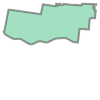

In [10]:
a = burbs.iloc[0]
print a
a.geometry

In [11]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

In [12]:
# ["macquarie" in x for x in list(nsw_csv.Suburb)]
postcodes[["macquarie" in x for x in list(postcodes.Suburb)]].Suburb.unique()

array(['macquarie university', 'macquarie centre', 'macquarie park',
       'macquarie hills', 'port macquarie', 'north macquarie',
       'macquarie fields', 'macquarie links', 'macquarie pass',
       'macquarie marshes'], dtype=object)

In [13]:
n = nsw_csv['Suburb'].str.lower().unique()
p = postcodes['Suburb'].str.lower().unique()

# print (n.unique())
# print (p.unique())

In [14]:
the_one = pcode_merged.merge(burbs[["geometry", "Suburb"]], on='Suburb')
the_one = GeoDataFrame(the_one)
print type(the_one)
the_one.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,Statistical Division or Subdivision,Suburb,Offence category,Subcategory,Jan-95,Feb-95,Mar-95,Apr-95,May-95,Jun-95,...,Jun-12,Jul-12,Aug-12,Sep-12,Oct-12,Nov-12,Dec-12,lat,lon,geometry
0,Inner Sydney,leichhardt,Homicide,Murder (a),0,0,0,0,0,0,...,0,0,0,0,0,0,0,-33.883793,151.157057,"POLYGON ((151.14968393187 -33.87386379763, 151..."
1,Inner Sydney,leichhardt,Homicide,Attempted murder,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-33.883793,151.157057,"POLYGON ((151.14968393187 -33.87386379763, 151..."


In [15]:
Offence_burb = the_one.groupby("Offence category").sum()
Offence_burb["Offence category"] = Offence_burb.index
Offence_burb.drop(["lat", "lon"], axis=1, inplace=True)
# Offence_burb = murder_burb.merge(burbs[["geometry", "Suburb"]], on='Suburb')
# Offence_burb = GeoDataFrame(Offence_burb)
Offence_burb.columns

# Offence_burb.plot(kind='bar', legend=False)

Index([u'Jan-95', u'Feb-95', u'Mar-95', u'Apr-95', u'May-95', u'Jun-95',
       u'Jul-95', u'Aug-95', u'Sep-95', u'Oct-95',
       ...
       u'Apr-12', u'May-12', u'Jun-12', u'Jul-12', u'Aug-12', u'Sep-12',
       u'Oct-12', u'Nov-12', u'Dec-12', u'Offence category'],
      dtype='object', length=217)

In [16]:
# murder_burb = the_one.groupby("Suburb").sum()
# murder_burb["Suburb"] = murder_burb.index
# murder_burb = murder_burb.merge(burbs[["geometry", "Suburb"]], on='Suburb')
# murder_burb = GeoDataFrame(murder_burb)

# murder_burb.head(5)

In [17]:
murder_burb =  the_one.groupby(["Subcategory", "Suburb"]).sum()
murder_burb["Suburb"] = murder_burb.index
# murder_burb = murder_burb.merge(burbs[["geometry", "Suburb"]], on='Suburb')

murder_burb.drop(["lat", "lon"], axis=1, inplace=True)
# murder_burb = GeoDataFrame(murder_burb)
# murder_burb_merge = murder_burb.merge(the_one, on='Suburb')
# murder_burb_merge["Suburb"] = murder_burb_merge.index

murder_burb.head(5)

Jan-95  Feb-95  Mar-95  Apr-95  May-95  Jun-95  \
Subcategory    Suburb                                                      
Assault Police albury         12       3       2       4       7       2   
               ashfield        0       0       0       4       0       0   
               auburn          4       0      10       0       0       2   
               ballina         2       1       1       1       0       0   
               balranald       0       0       0       0       0       0   

                          Jul-95  Aug-95  Sep-95  Oct-95  \
Subcategory    Suburb                                      
Assault Police albury          8       3       0       3   
               ashfield        4       0       0       0   
               auburn          0       8       0       0   
               ballina         0       1       0       0   
               balranald       0       0       0       0   

                                     ...               Apr-12  May-12  Jun-12  \
Subcategory    Suburb                ...                                        
Assault Police albury                ...                    6       1       1   
               ashfield              ...                    0       2       0   
               auburn                ...                    2       2       6   
               ballina               ...                    1       0       1   
               balranald             ...                    0       0       0   

                          Jul-12  Aug-12  Sep-12  Oct-12  Nov-12  Dec-12  \
Subcategory    Suburb                                                      
Assault Police albury          3       3       1       0       1       2   
               ashfield        4       0       4       0       2       2   
               auburn          6       4       6       6       4       2   
               ballina         0       0       0       1       0       0   
               balranald       0       0       0       0       0       0   

                                               Suburb  
Subcategory    Suburb                                  
Assault Police albury        (Assault Police, albury)  
               ashfield    (Assault Police, ashfield)  
               auburn        (Assault Police, auburn)  
               ballina      (Assault Police, ballina)  
               balranald  (Assault Police, balranald)  

[5 rows x 217 columns]

<class 'pandas.core.frame.DataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


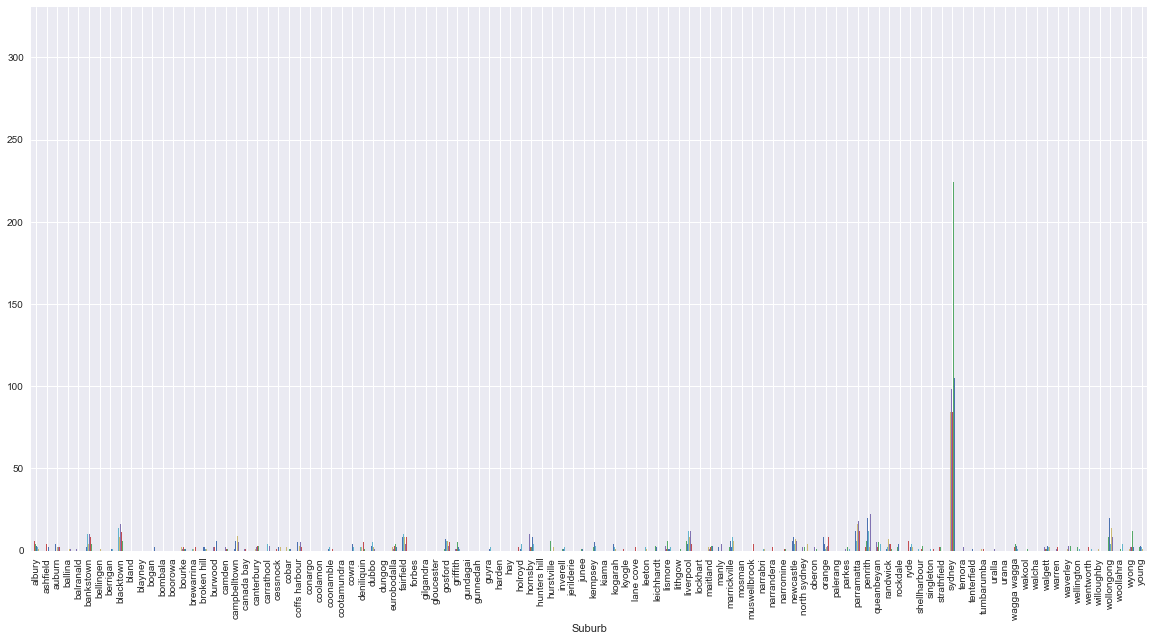

In [19]:
print type (murder_burb)
print type (burbs)
# print the_one['Offence category']
# print (murder_burb.loc["Assault Police"])
murder_burb_ass = murder_burb.loc["Assault Police"]

murder_burb_ass.plot(kind="bar", legend=False)

In [20]:
murder_burb.index.levels[0]

Index([u'Assault Police', u'Attempted murder',
       u'Breach Apprehended Violence Order', u'Breach bail conditions',
       u'Break and enter dwelling', u'Break and enter non-dwelling',
       u'Criminal intent', u'Cultivating cannabis',
       u'Dealing, trafficking in amphetamines',
       u'Dealing, trafficking in cannabis', u'Dealing, trafficking in cocaine',
       u'Dealing, trafficking in ecstasy',
       u'Dealing, trafficking in narcotics',
       u'Dealing, trafficking in other drugs',
       u'Domestic violence related assault', u'Escape custody',
       u'Fail to appear', u'Fraud', u'Importing drugs',
       u'Indecent assault, act of indecency and other sexual offences',
       u'Manslaughter (a)', u'Manufacture drug', u'Motor vehicle theft',
       u'Murder (a)', u'Murder accessory, conspiracy',
       u'Non-domestic violence related assault', u'Offensive conduct',
       u'Offensive language', u'Other drug offences',
       u'Other offences against justice procedures',

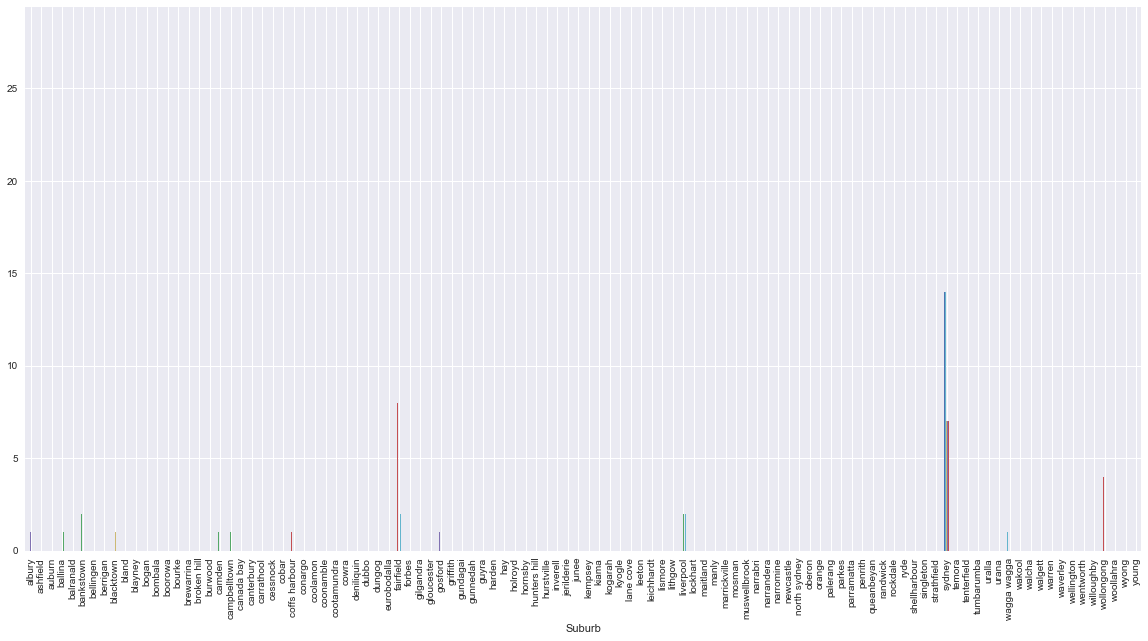

In [21]:
mba = murder_burb.loc["Attempted murder"]

mba.plot(kind='bar', legend=False)

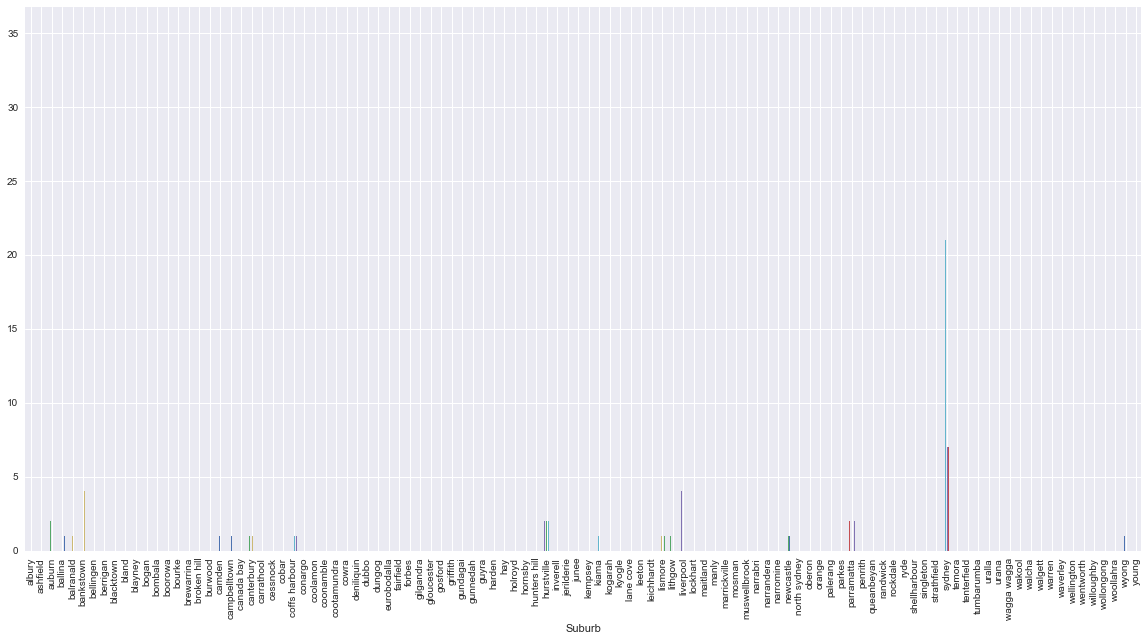

In [24]:
mbmu = murder_burb.loc["Murder (a)"]

mbmu.plot(kind='bar', legend=False)

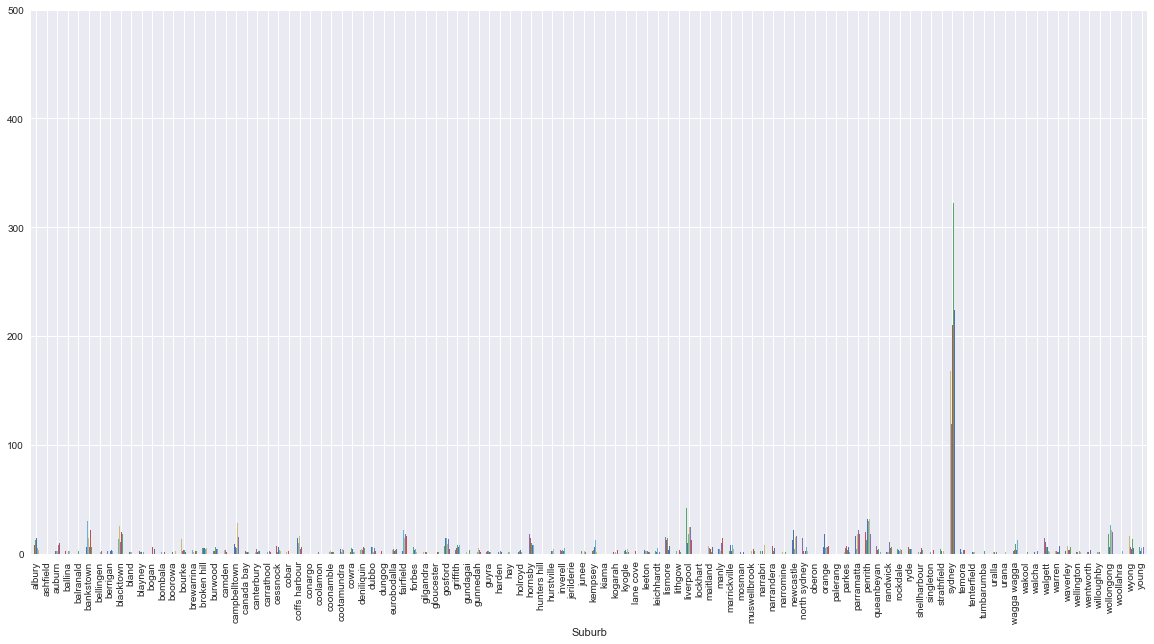

In [25]:
mbol = murder_burb.loc["Offensive language"]

mbol.plot(kind='bar', legend=False)

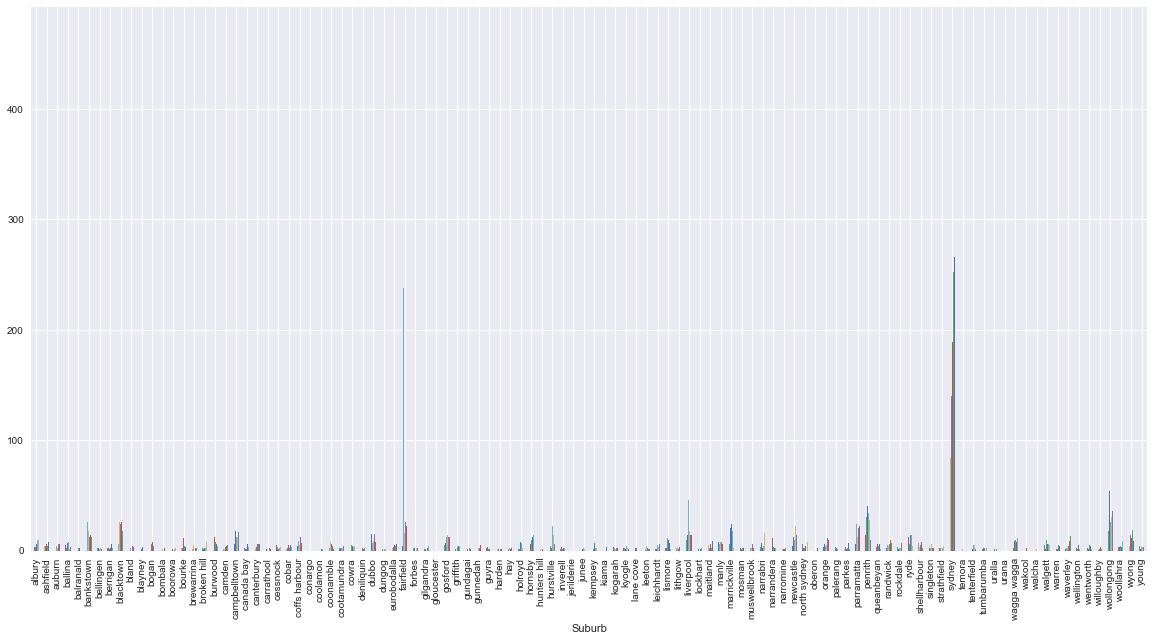

In [26]:
mbtr = murder_burb.loc["Trespass"]

mbtr.plot(kind='bar', legend=False)

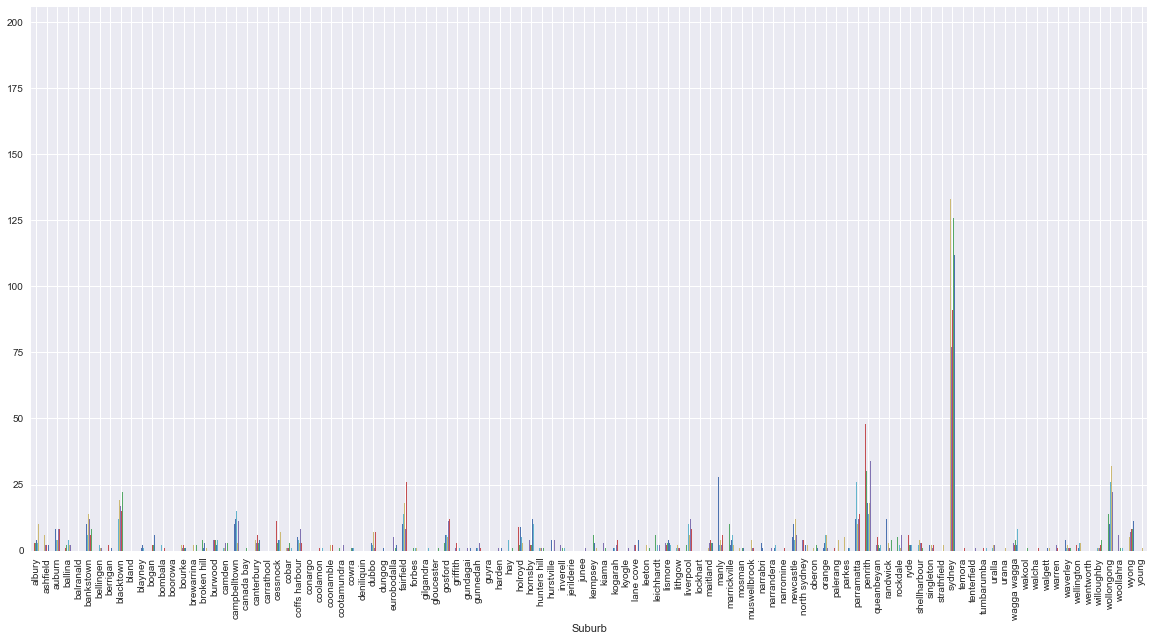

In [27]:
mbsa = murder_burb.loc["Sexual assault"]

mbsa.plot(kind='bar', legend=False)

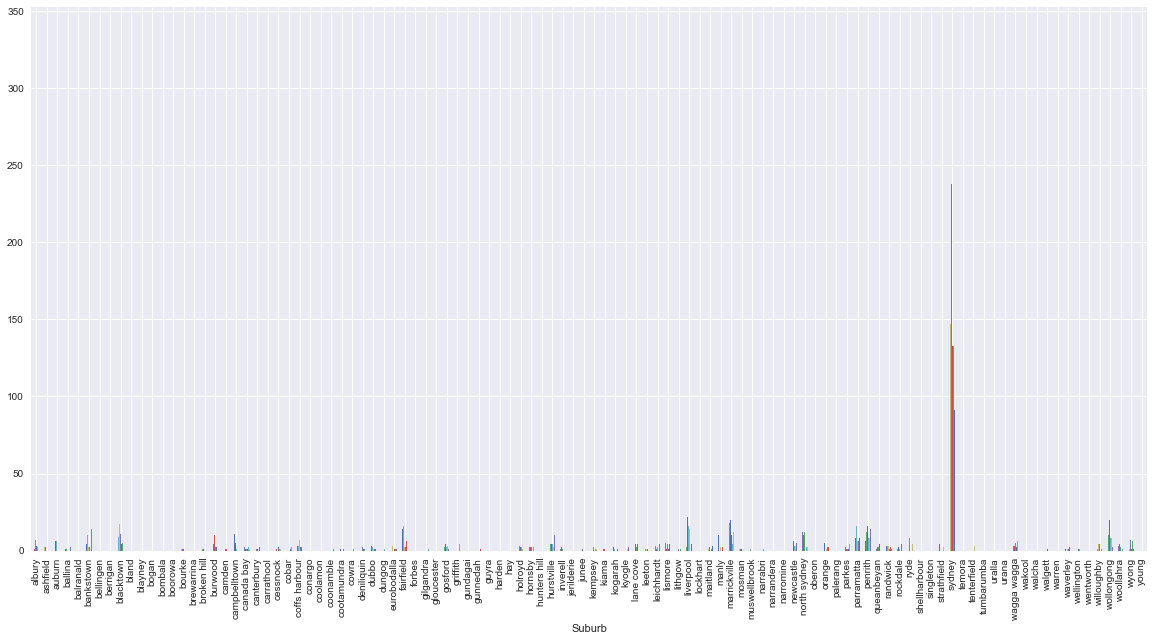

In [28]:
mbci = murder_burb.loc["Criminal intent"]

mbci.plot(kind='bar', legend=False)

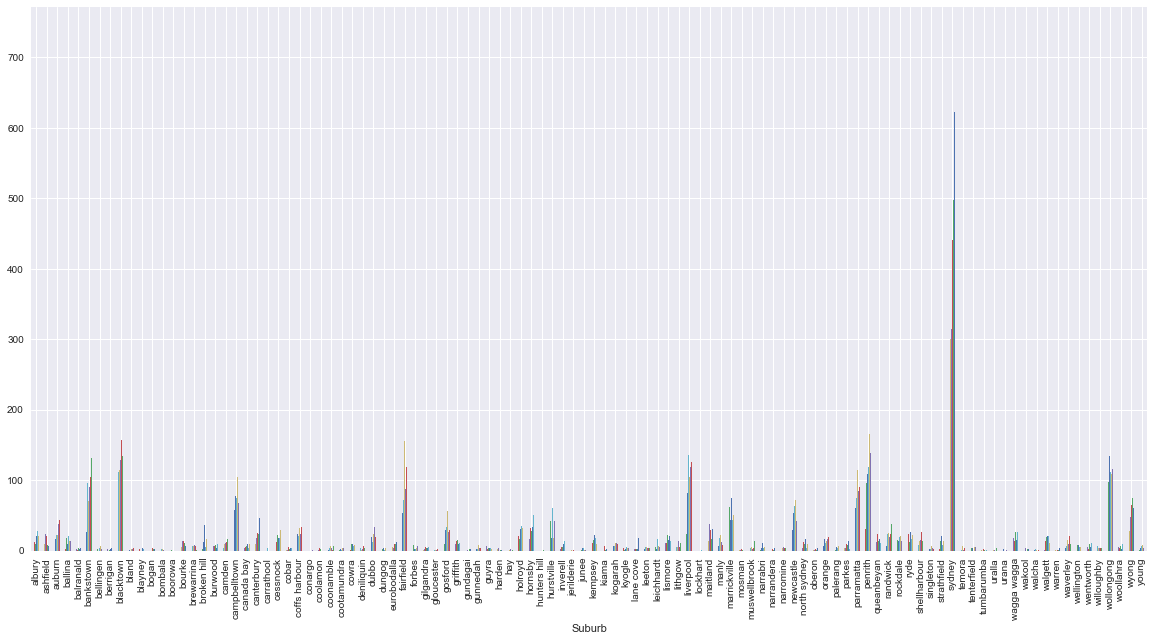

In [30]:
mbdv = murder_burb.loc["Domestic violence related assault"]

mbdv.plot(kind='bar', legend=False)

In [36]:
murder_burb['Suburb'].value_counts()

(Cultivating cannabis, kyogle)                                             1
(Domestic violence related assault, rockdale)                              1
(Breach Apprehended Violence Order, parkes)                                1
(Dealing, trafficking in cocaine, junee)                                   1
(Possession and/or use of ecstasy, junee)                                  1
(Dealing, trafficking in ecstasy, wellington)                              1
(Trespass, canterbury)                                                     1
(Other drug offences, strathfield)                                         1
(Manufacture drug, cootamundra)                                            1
(Steal from dwelling, hay)                                                 1
(Steal from retail store, bombala)                                         1
(Murder accessory, conspiracy, kyogle)                                     1
(Offensive conduct, lockhart)                                              1

In [ ]:
# for idx, row in murder_burb.iterrows():
#     plt.annotate(s=row.NSW_LOCA_2, 
#                  xy=tuple(row.centroid.coords)[0],
#                  horizontalalignment='center')
# plt.title("Some pretty dodgy suburb names on a map");

In [ ]:
# murder_data = murder_burb_ass["Suburb"][murder_burb_ass["Suburb"] > 1000]

# plt.hist(murder_data, bins=10, facecolor='blue', alpha=0.2) #<-old one
# plt.hist(murder_data, bins=50, facecolor='green', alpha=1)  #<-new one
# plt.show()

In [ ]:
# murder_dict = dict(column= "Jan-95", colormap="jet")
# murder_burb.plot(kind='bar');

In [ ]:
# murder_burb_albury = murder_burb[(murder_burb["Suburb"] == "albury")]
# murder_burb_albury
# murder_burb_ass.plot(ax=burbs.plot(alpha=0.1), cmap="magma")
# bounds = murder_burb.geometry.bounds

# plt.xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
# plt.ylim([bounds.miny.min()-5, bounds.maxy.max()+5])

In [ ]:
# murder_burb.plot(ax=burbs.plot(alpha=0.1), cmap="magma")
